# Aerospike Connect for Spark Tutorial for Python
## Tested with Java 8, Spark 2.4.0, and Python 3.7

### Setup

Below, a seed address for your Aerospike database cluster is required

Check the given namespace is available, and your feature key is located as per AS_FEATURE_KEY_PATH

Finally, review https://www.aerospike.com/enterprise/download/connectors/ to ensure AEROSPIKE_SPARK_JAR_VERSION is correct

In [1]:
# IP Address or DNS name for one host in your Aerospike cluster
AS_HOST ="10.0.0.95"
# Name of one of your namespaces. Type 'show namespaces' at the aql prompt if you are not sure
AS_NAMESPACE = "test" 
AS_FEATURE_KEY_PATH = "/etc/aerospike/features.conf"
AEROSPIKE_SPARK_JAR_VERSION="2.4.0"

AS_PORT = 3000 # Usually 3000, but change here if not
AS_CONNECTION_STRING = AS_HOST + ":"+ str(AS_PORT)

In [2]:
# Next we locate the Spark installation - this will be found using the SPARK_HOME environment variable that you will have set 
# if you followed the repository README

import findspark
findspark.init()

In [3]:
# Here we download the Aerospike Spark jar
import urllib
import os

def aerospike_spark_jar_download_url(version=AEROSPIKE_SPARK_JAR_VERSION):
    DOWNLOAD_PREFIX="https://www.aerospike.com/enterprise/download/connectors/aerospike-spark/"
    DOWNLOAD_SUFFIX="/artifact/jar"
    AEROSPIKE_SPARK_JAR_DOWNLOAD_URL = DOWNLOAD_PREFIX+AEROSPIKE_SPARK_JAR_VERSION+DOWNLOAD_SUFFIX
    return AEROSPIKE_SPARK_JAR_DOWNLOAD_URL

def download_aerospike_spark_jar(version=AEROSPIKE_SPARK_JAR_VERSION):
    JAR_NAME="aerospike-spark-assembly-"+AEROSPIKE_SPARK_JAR_VERSION+".jar"
    if(not(os.path.exists(JAR_NAME))) :
        urllib.request.urlretrieve(aerospike_spark_jar_download_url(),JAR_NAME)
    else :
        print(JAR_NAME+" already downloaded")
    return os.path.join(os.getcwd(),JAR_NAME)

AEROSPIKE_JAR_PATH=download_aerospike_spark_jar()
os.environ["PYSPARK_SUBMIT_ARGS"] = '--jars ' + AEROSPIKE_JAR_PATH + ' pyspark-shell'



aerospike-spark-assembly-2.4.0.jar already downloaded


In [4]:
import pyspark
from pyspark.context import SparkContext
from pyspark.sql.context import SQLContext
from pyspark.sql.session import SparkSession
from pyspark.sql.types import StringType, StructField, StructType, ArrayType, IntegerType, MapType, LongType, DoubleType

Get a spark session object and set required Aerospike configuration properties

In [5]:
sc = SparkContext.getOrCreate()
spark = SparkSession(sc)
sqlContext = SQLContext(sc)
spark.conf.set("aerospike.namespace",AS_NAMESPACE)
spark.conf.set("aerospike.seedhost",AS_CONNECTION_STRING)
spark.conf.set("aerospike.keyPath",AS_FEATURE_KEY_PATH )


## Create realistic sample data

In [6]:
# We create age vs salary data, using three different Gaussian distributions
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math

# Create covariance matrix from std devs + correlation
def covariance_matrix(std_dev_1,std_dev_2,correlation):
    return [[std_dev_1 ** 2, correlation * std_dev_1 * std_dev_2], 
           [correlation * std_dev_1 * std_dev_2, std_dev_2 ** 2]]

# Return a bivariate sample given means/std dev/correlation
def age_salary_sample(distribution_params,sample_size):
    mean = [distribution_params["age_mean"], distribution_params["salary_mean"]]
    cov = covariance_matrix(distribution_params["age_std_dev"],distribution_params["salary_std_dev"],
                            distribution_params["age_salary_correlation"])
    return np.random.multivariate_normal(mean, cov, sample_size).T

# Define the characteristics of our age/salary distribution
age_salary_distribution_1 = {"age_mean":25,"salary_mean":50000,
                             "age_std_dev":1,"salary_std_dev":5000,"age_salary_correlation":0.3}

age_salary_distribution_2 = {"age_mean":45,"salary_mean":80000,
                             "age_std_dev":4,"salary_std_dev":10000,"age_salary_correlation":0.7}

age_salary_distribution_3 = {"age_mean":35,"salary_mean":70000,
                             "age_std_dev":2,"salary_std_dev":9000,"age_salary_correlation":0.1}

distribution_data = [age_salary_distribution_1,age_salary_distribution_2,age_salary_distribution_3]

# Sample age/salary data for each distributions
group_1_ages,group_1_salaries = age_salary_sample(age_salary_distribution_1,sample_size=100)
group_2_ages,group_2_salaries = age_salary_sample(age_salary_distribution_2,sample_size=120)
group_3_ages,group_3_salaries = age_salary_sample(age_salary_distribution_3,sample_size=80)

ages=np.concatenate([group_1_ages,group_2_ages,group_3_ages])
salaries=np.concatenate([group_1_salaries,group_2_salaries,group_3_salaries])

print("Data created")

Data created


### Display simulated age/salary data

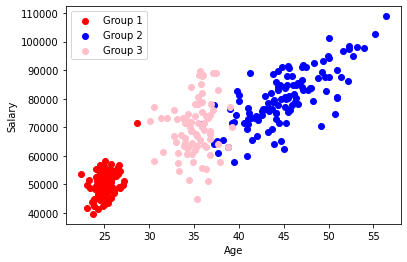

In [7]:
# Plot the sample data
group_1_colour, group_2_colour, group_3_colour ='red','blue', 'pink'
plt.xlabel('Age',fontsize=10)
plt.ylabel("Salary",fontsize=10) 

plt.scatter(group_1_ages,group_1_salaries,c=group_1_colour,label="Group 1")
plt.scatter(group_2_ages,group_2_salaries,c=group_2_colour,label="Group 2")
plt.scatter(group_3_ages,group_3_salaries,c=group_3_colour,label="Group 3")

plt.legend(loc='upper left')
plt.show()

### Save data to Aerospike

In [8]:
# Turn the above records into a Data Frame
# First of all, create an array of arrays
inputBuf = []

for  i in range(0, len(ages)) :
     id = i + 1 # Avoid counting from zero
     name = "Individual: {:03d}".format(id)
     # Note we need to make sure values are typed correctly
     # salary will have type numpy.float64 - if it is not cast as below, an error will be thrown
     age = float(ages[i])
     salary = int(salaries[i])
     inputBuf.append((id, name,age,salary))

# Convert to an RDD 
inputRDD = spark.sparkContext.parallelize(inputBuf)
       
# Convert to a data frame using a schema
schema = StructType([
    StructField("id", IntegerType(), True),
    StructField("name", StringType(), True),
    StructField("age", DoubleType(), True),
    StructField("salary",IntegerType(), True)
])

inputDF=spark.createDataFrame(inputRDD,schema)

#Write the data frame to Aerospike, the id field is used as the primary key
inputDF \
.write \
.mode('overwrite') \
.format("com.aerospike.spark.sql")  \
.option("aerospike.set", "salary_data")\
.option("aerospike.updateByKey", "id") \
.save()

## Use of schema

Aerospike is schemaless, however Spark data frames do. If a schema is not explicitly supplied it will 
be inferred from the data within the data frame.

Once this takes place, data within the data frame must honor the types. 

To infer schema, the connector samples a set of records (configurable through `aerospike.schema.scan`) to decide the name of bins/columns and their types. 


## Load data into a DataFrame without specifying any Schema (uses schema inference)

In [9]:
# Create a Spark DataFrame by using the Connector Schema inference mechanism
# The fields preceded with __ are metadata fields - key/digest/expiry/generation/ttl
# By default you just get everything, with no column ordering, which is why it looks untidy
# Note we don't get anything in the 'key' field as we have not chosen to save as a bin.
# Use .option("aerospike.sendKey", True) to do this

loadedDFWithoutSchema = (
    spark.read.format("com.aerospike.spark.sql") \
    .option("aerospike.set", "salary_data") \
    .load()
)

loadedDFWithoutSchema.show(10)

+-----+--------------------+--------+------------+-----+------------------+---------------+------+---+
|__key|            __digest|__expiry|__generation|__ttl|               age|           name|salary| id|
+-----+--------------------+--------+------------+-----+------------------+---------------+------+---+
| null|[03 50 2E 7F 70 9...|       0|           7|   -1| 35.06781727794353|Individual: 239| 74009|239|
| null|[04 C0 5E 9A 68 5...|       0|           7|   -1|43.288503968706706|Individual: 101| 78451|101|
| null|[0F 10 1A 93 B1 E...|       0|           7|   -1| 37.24285145763098|Individual: 194| 64256|194|
| null|[1A E0 A8 A0 F2 3...|       0|           7|   -1| 24.10582122289297|Individual: 031| 49287| 31|
| null|[23 20 78 35 5D 7...|       0|           7|   -1| 44.12087589052535|Individual: 139| 74910|139|
| null|[35 00 8C 78 43 F...|       0|           7|   -1| 24.71596918274671|Individual: 014| 49412| 14|
| null|[37 00 6D 21 08 9...|       0|           7|   -1| 52.3348711106516

## Load data into a DataFrame using user specified schema 

In [10]:
# If we explicitly set the schema, using the previously created schema object
# we effectively type the rows in the Data Frame

loadedDFWithSchema=spark \
.read \
.format("com.aerospike.spark.sql") \
.schema(schema) \
.option("aerospike.set", "salary_data").load()

loadedDFWithSchema.show(5)

+---+---------------+------------------+------+
| id|           name|               age|salary|
+---+---------------+------------------+------+
|239|Individual: 239| 35.06781727794353| 74009|
|101|Individual: 101|43.288503968706706| 78451|
|194|Individual: 194| 37.24285145763098| 64256|
| 31|Individual: 031| 24.10582122289297| 49287|
|139|Individual: 139| 44.12087589052535| 74910|
+---+---------------+------------------+------+
only showing top 5 rows



## Working with complex Data Types (CDT) in Aerospike

### Save json into Aerospike using a schema

In [11]:
# Schema specification
aliases_type = StructType([
    StructField("first_name",StringType(),False),
    StructField("last_name",StringType(),False)
])

id_type = StructType([
    StructField("first_name",StringType(),False), 
    StructField("last_name",StringType(),False), 
    StructField("aliases",ArrayType(aliases_type),False)
])

street_adress_type = StructType([
    StructField("street_name",StringType(),False), 
    StructField("apt_number",IntegerType(),False)
])

address_type = StructType([
    StructField("zip",LongType(),False), 
    StructField("street",street_adress_type,False), 
    StructField("city",StringType(),False)
])

workHistory_type = StructType([
    StructField ("company_name",StringType(),False),
    StructField( "company_address",address_type,False),
    StructField("worked_from",StringType(),False)
])

person_type = StructType([
    StructField("name",id_type,False),
    StructField("SSN",StringType(),False),
    StructField("home_address",ArrayType(address_type),False),
    StructField("work_history",ArrayType(workHistory_type),False)
])

# JSON data location
complex_data_json="resources/nested_data.json"

# Read data in using prepared schema
cmplx_data_with_schema=spark.read.schema(person_type).json(complex_data_json)

# Save data to Aerospike
cmplx_data_with_schema \
.write \
.mode('overwrite') \
.format("com.aerospike.spark.sql")  \
.option("aerospike.writeset", "complex_input_data") \
.option("aerospike.updateByKey", "name.first_name") \
.save()

### Retrieve CDT from Aerospike into a DataFrame using schema 

In [12]:
loadedComplexDFWithSchema=spark \
.read \
.format("com.aerospike.spark.sql") \
.option("aerospike.set", "complex_input_data") \
.schema(person_type) \
.load() 
loadedComplexDFWithSchema.show(5)

+--------------------+-----------+--------------------+--------------------+
|                name|        SSN|        home_address|        work_history|
+--------------------+-----------+--------------------+--------------------+
|[Maria, Bates, [[...|165-16-6030|[[2399, [Ebony Un...|[[Adams-Guzman, [...|
|[Brenda, Gonzales...|396-98-0954|[[63320, [Diane O...|[[Powell Group, [...|
|[Bryan, Davis, [[...|682-39-2482|[[47508, [Cooper ...|[[Rivera-Ruiz, [1...|
|[Tami, Jordan, [[...|001-49-0685|[[23288, [Clark V...|[[Roberts PLC, [4...|
|[Connie, Joyce, [...|369-38-9885|[[27216, [Goodman...|[[Pugh, Walsh and...|
+--------------------+-----------+--------------------+--------------------+
only showing top 5 rows



## Data Exploration with Aerospike 

In [13]:
import pandas
import matplotlib
import matplotlib.pyplot as plt

#convert spark df to pandas df
pdf = loadedDFWithSchema.toPandas()

# Describe the data

pdf.describe()

,id,age,salary
count,300.000000,300.000000,300.000000
mean,150.500000,35.798710,67583.450000
std,86.746758,9.007555,15333.729363
min,1.000000,22.440617,39626.000000
25%,75.750000,25.743968,53313.500000
50%,150.500000,35.828127,68630.500000
75%,225.250000,43.910378,79369.750000
max,300.000000,56.351925,108870.000000


22 57


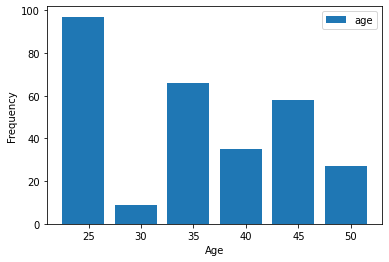

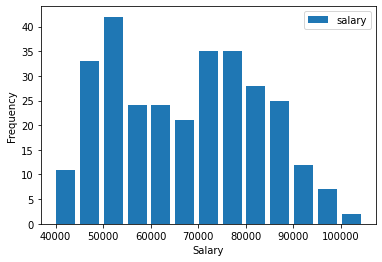

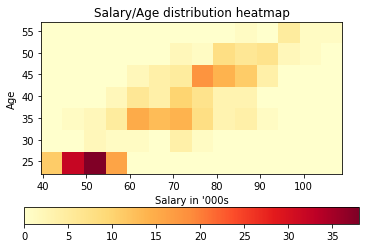

In [14]:
#Histogram - Age
age_min, age_max = int(np.amin(pdf['age'])), math.ceil(np.amax(pdf['age']))
age_bucket_size = 5
print(age_min,age_max)
pdf[['age']].plot(kind='hist',bins=range(age_min,age_max,age_bucket_size),rwidth=0.8)
plt.xlabel('Age',fontsize=10)
plt.legend(loc=None)
plt.show()

#Histogram - Salary
salary_min, salary_max = int(np.amin(pdf['salary'])), math.ceil(np.amax(pdf['salary']))
salary_bucket_size = 5000
pdf[['salary']].plot(kind='hist',bins=range(salary_min,salary_max,salary_bucket_size),rwidth=0.8)
plt.xlabel('Salary',fontsize=10)
plt.legend(loc=None)
plt.show()

# Heatmap
age_bucket_count = math.ceil((age_max - age_min)/age_bucket_size)
salary_bucket_count = math.ceil((salary_max - salary_min)/salary_bucket_size)

x = [[0 for i in range(salary_bucket_count)] for j in range(age_bucket_count)]
for i in range(len(pdf['age'])):
    age_bucket = math.floor((pdf['age'][i] - age_min)/age_bucket_size)
    salary_bucket = math.floor((pdf['salary'][i] - salary_min)/salary_bucket_size)
    x[age_bucket][salary_bucket] += 1

plt.title("Salary/Age distribution heatmap")
plt.xlabel("Salary in '000s")
plt.ylabel("Age")

plt.imshow(x, cmap='YlOrRd', interpolation='nearest',extent=[salary_min/1000,salary_max/1000,age_min,age_max],
           origin="lower")
plt.colorbar(orientation="horizontal")
plt.show()

# Querying Aerospike Data using SparkSQL
## Notes   
1. Queries using the  primary key will use batch gets - https://www.aerospike.com/docs/client/c/usage/kvs/batch.html] and run fast. 
2. All other queries may entail a full scan of the Aerospike DB if they can’t be converted to Aerospike batch get. 

## Queries that include Primary Key in the Predicate

With batch get queries we can apply filters on metadata columns such as `__gen` or `__ttl`. To do this, these columns should be exposed through the schema.

In [15]:
# Basic PKey query
batchGet1= spark \
.read \
.format("com.aerospike.spark.sql") \
.option("aerospike.set", "salary_data") \
.option("aerospike.keyType", "int") \
.load().where("__key = 100") \

batchGet1.show()
#Note ASDB only supports equality test with PKs in primary key query. 
#So, a where clause with "__key >10", would result in scan query!

+-----+--------------------+--------+------------+-----+------------------+---------------+------+---+
|__key|            __digest|__expiry|__generation|__ttl|               age|           name|salary| id|
+-----+--------------------+--------+------------+-----+------------------+---------------+------+---+
|  100|[82 46 D4 AF BB 7...|       0|           7|   -1|26.559369147069145|Individual: 100| 56039|100|
+-----+--------------------+--------+------------+-----+------------------+---------------+------+---+



In [16]:
# Batch get, primary key based query
from pyspark.sql.functions import col
somePrimaryKeys= list(range(1,10))
someMoreKeys= list(range(12,14))
batchGet2= spark \
.read \
.format("com.aerospike.spark.sql") \
.option("aerospike.set", "salary_data") \
.option("aerospike.keyType", "int") \
.load().where((col("__key").isin(somePrimaryKeys)) | ( col("__key").isin(someMoreKeys))) 

batchGet2.show(5)

+-----+--------------------+--------+------------+-----+------------------+---------------+------+---+
|__key|            __digest|__expiry|__generation|__ttl|               age|           name|salary| id|
+-----+--------------------+--------+------------+-----+------------------+---------------+------+---+
|   13|[27 B2 50 19 5B 5...|       0|           7|   -1|25.814383603923734|Individual: 013| 52676| 13|
|    5|[CC 73 E2 C2 23 2...|       0|           7|   -1| 24.57513467709537|Individual: 005| 50422|  5|
|    1|[85 36 18 55 4C B...|       0|           7|   -1|25.215514053683076|Individual: 001| 44578|  1|
|    9|[EB 86 7C 94 AA 4...|       0|           7|   -1|23.130331531212015|Individual: 009| 49930|  9|
|    3|[B1 E9 BC 33 C7 9...|       0|           7|   -1|25.836291804136646|Individual: 003| 52328|  3|
+-----+--------------------+--------+------------+-----+------------------+---------------+------+---+
only showing top 5 rows



## Queries including non-primary key conditions

In [17]:
# This query will run as a scan, which will be slower
somePrimaryKeys= list(range(1,10))
scanQuery1= spark \
.read \
.format("com.aerospike.spark.sql") \
.option("aerospike.set", "salary_data") \
.option("aerospike.keyType", "int") \
.load().where((col("__key").isin(somePrimaryKeys)) | ( col("age") >50 ))

scanQuery1.show()

+-----+--------------------+--------+------------+-----+------------------+---------------+------+---+
|__key|            __digest|__expiry|__generation|__ttl|               age|           name|salary| id|
+-----+--------------------+--------+------------+-----+------------------+---------------+------+---+
| null|[37 00 6D 21 08 9...|       0|           7|   -1| 52.33487111065165|Individual: 142| 98614|142|
| null|[D8 41 95 28 82 F...|       0|           7|   -1| 50.97648718774525|Individual: 159| 80345|159|
| null|[53 52 6E C1 56 F...|       0|           7|   -1| 52.28627064669629|Individual: 161| 97336|161|
| null|[6E 92 74 77 95 D...|       0|           7|   -1| 50.90327926559967|Individual: 196| 90179|196|
| null|[7F 42 20 2F 69 8...|       0|           7|   -1| 50.71240107403744|Individual: 117| 74618|117|
| null|[BC 23 79 79 BE A...|       0|           7|   -1| 50.96710371399207|Individual: 152| 80726|152|
| null|[F8 44 7A 4A 5A 5...|       0|           7|   -1| 53.2055603163229

## Query using CDT

In [18]:
#Find people who have had at least 5 jobs in the past
from pyspark.sql.functions import col, size

loadedComplexDFWithSchema \
.withColumn("past_jobs", col("work_history.company_name")) \
.withColumn("num_jobs", size(col("past_jobs")))  \
.where(col("num_jobs") > 4) \
.show(5)

+--------------------+-----------+--------------------+--------------------+--------------------+--------+
|                name|        SSN|        home_address|        work_history|           past_jobs|num_jobs|
+--------------------+-----------+--------------------+--------------------+--------------------+--------+
|[Tami, Jordan, [[...|001-49-0685|[[23288, [Clark V...|[[Roberts PLC, [4...|[Roberts PLC, Hub...|       5|
|[Chelsea, Clark, ...|465-88-7213|[[49305, [Ward By...|[[Ochoa and Sons,...|[Ochoa and Sons, ...|       5|
|[Jonathan, Smith,...|526-54-7792|[[71421, [William...|[[Henderson-Shaw,...|[Henderson-Shaw, ...|       5|
|[Gary, Spencer, [...|825-55-3247|[[66428, [Kim Mil...|[[Bishop, Scott a...|[Bishop, Scott an...|       5|
|[Danielle, Deleon...|319-30-0983|[[63276, [Bauer C...|[[Powers LLC, [60...|[Powers LLC, Powe...|       5|
+--------------------+-----------+--------------------+--------------------+--------------------+--------+
only showing top 5 rows



## Parameters for tuning Aerospike / Spark performance

  - aerospike.partition.factor: number of logical aerospike partitions [0-15]
  - aerospike.maxthreadcount : maximum number of threads to use for writing data into Aerospike
  - aerospike.compression : compression of java client-server communication
  - aerospike.batchMax : maximum number of records per read request (default 5000)
  - aerospike.recordspersecond : same as java client

## Other useful parameters
  - aerospike.keyType : Primary key type hint for schema inference. Always set it properly if primary key type is not string  

See https://www.aerospike.com/docs/connect/processing/spark/reference.html for detailed description of the above properties


# Machine Learning using Aerospike / Spark

In this section we use the data we took from Aerospike and apply a clustering algorithm to it.

We assume the data is composed of multiple data sets having a Gaussian multi-variate distribution

We don't know how many clusters there are, so we try clustering based on the assumption there are 1 through 20.

We compare the quality of the results using the Bayesian Information Criterion - https://en.wikipedia.org/wiki/Bayesian_information_criterion and pick the best.
    
## Find Optimal Cluster Count    

In [19]:
from sklearn.mixture import GaussianMixture

# We take the data we previously 
ages=pdf['age']
salaries=pdf['salary']
age_salary_matrix=np.matrix([ages,salaries]).T

# Find the optimal number of clusters
optimal_cluster_count = 1
best_bic_score = GaussianMixture(1).fit(age_salary_matrix).bic(age_salary_matrix)

for count in range(1,20):
    gm=GaussianMixture(count)
    gm.fit(age_salary_matrix)
    if gm.bic(age_salary_matrix) < best_bic_score:
        best_bic_score = gm.bic(age_salary_matrix)
        optimal_cluster_count = count

print("Optimal cluster count found to be "+str(optimal_cluster_count))

Optimal cluster count found to be 3


## Estimate cluster distribution parameters
Next we fit our cluster using the optimal cluster count, and print out the discovered means and covariance matrix

In [20]:
gm = GaussianMixture(optimal_cluster_count)
gm.fit(age_salary_matrix)

estimates = []
# Index
for index in range(0,optimal_cluster_count):
    estimated_mean_age = round(gm.means_[index][0],2)
    estimated_mean_salary = round(gm.means_[index][1],0)
    estimated_age_std_dev = round(math.sqrt(gm.covariances_[index][0][0]),2)
    estimated_salary_std_dev = round(math.sqrt(gm.covariances_[index][1][1]),0)
    estimated_correlation = round(gm.covariances_[index][0][1] / ( estimated_age_std_dev * estimated_salary_std_dev ),3)
    row = [estimated_mean_age,estimated_mean_salary,estimated_age_std_dev,estimated_salary_std_dev,estimated_correlation]
    estimates.append(row)
    
pd.DataFrame(estimates,columns = ["Est Mean Age","Est Mean Salary","Est Age Std Dev","Est Salary Std Dev","Est Correlation"])    


,Est Mean Age,Est Mean Salary,Est Age Std Dev,Est Salary Std Dev,Est Correlation
0,45.56,80969.0,3.90,9721.0,0.762
1,25.10,50276.0,0.93,4078.0,0.327
2,35.43,70001.0,2.24,9391.0,0.176


## Original Distribution Parameters

In [21]:
distribution_data_as_rows = []
for distribution in distribution_data:
    row = [distribution['age_mean'],distribution['salary_mean'],distribution['age_std_dev'],
                             distribution['salary_std_dev'],distribution['age_salary_correlation']]
    distribution_data_as_rows.append(row)

pd.DataFrame(distribution_data_as_rows,columns = ["Mean Age","Mean Salary","Age Std Dev","Salary Std Dev","Correlation"])

,Mean Age,Mean Salary,Age Std Dev,Salary Std Dev,Correlation
0,25,50000,1,5000,0.3
1,45,80000,4,10000,0.7
2,35,70000,2,9000,0.1


You can see that the algorithm provides good estimates of the original parameters

## Prediction

We generate new age/salary pairs for each of the distributions and look at how accurate the prediction is

In [22]:
def prediction_accuracy(model,age_salary_distribution,sample_size):
    # Generate new values
    new_ages,new_salaries = age_salary_sample(age_salary_distribution,sample_size)
    new_age_salary_matrix=np.matrix([new_ages,new_salaries]).T
    # Find which cluster the mean would be classified into
    mean = np.matrix([age_salary_distribution['age_mean'],age_salary_distribution['salary_mean']])
    mean_cluster_index = model.predict(mean)[0]
    # How would new samples be classified
    classification = model.predict(new_age_salary_matrix)
    # How many were classified correctly
    correctly_classified = len([ 1 for x in classification if x  == mean_cluster_index])
    return correctly_classified / sample_size

prediction_accuracy_results = [None for x in range(3)]
for index, age_salary_distribution in enumerate(distribution_data):
    prediction_accuracy_results[index] = prediction_accuracy(gm,age_salary_distribution,1000)

overall_accuracy = sum(prediction_accuracy_results)/ len(prediction_accuracy_results)
print("Accuracies for each distribution : "," ,".join(map('{:.2%}'.format,prediction_accuracy_results)))
print("Overall accuracy : ",'{:.2%}'.format(overall_accuracy))


Accuracies for each distribution :  99.90% ,90.30% ,98.30%
Overall accuracy :  96.17%
